[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Fisher_1991/fig_2.ipynb)

# based on Fig 2. in [Fisher 1991](https://doi.org/10.1034/j.1600-0889.1991.t01-4-00006.x)
Deuterium excess $d=\delta(D) - 8\delta( ^{18}O)$

In [1]:
import sys
if "google.colab" in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab("PySDM-examples")

In [2]:
from matplotlib import pyplot
import numpy as np
from open_atmos_jupyter_utils import show_plot
from scipy.integrate import solve_ivp
from functools import partial

from PySDM import Formulae
from PySDM.physics import si
from PySDM.physics.constants import PER_MILLE, in_unit
from PySDM_examples.Jouzel_and_Merlivat_1984.thermodynamic_profiles import (
    vapour_mixing_ratio,
)

In [3]:
formulae = Formulae(
    drop_growth="Mason1971",
    diffusion_thermics="Neglect",
    latent_heat_vapourisation="Constant",
    isotope_meteoric_water_line="Dansgaard1964",
    isotope_diffusivity_ratios="Stewart1975",
    isotope_equilibrium_fractionation_factors="VanHook1968",
    isotope_kinetic_fractionation_factors="BolotEtAl2013",
)
const = formulae.constants

In [4]:
temperature = np.linspace(230, 260, 10) * si.K
D = formulae.diffusion_thermics.D(1, 1) # TODO
K = formulae.diffusion_thermics.K(1, 1)

molar_mass_isotopes = {
    "2H": const.M_1H + const.M_2H + const.M_16O,
    "18O": 2 * const.M_1H + const.M_18O,
}
svp = formulae.saturation_vapour_pressure
Si = svp.pvs_water(temperature) / svp.pvs_ice(temperature)
r_dr_dt = formulae.drop_growth.r_dr_dt(
    RH_eq=0,
    T=temperature,
    RH=Si,
    lv=formulae.latent_heat_vapourisation.lv(temperature),
    pvs=svp.pvs_water(temperature),
    D=D,
    K=K,
)

In [5]:
yf = partial(vapour_mixing_ratio, formulae=formulae)
alpha_s = {}
for iso in molar_mass_isotopes.keys():
    alpha_s[iso] = getattr(formulae.isotope_equilibrium_fractionation_factors, f'alpha_i_{iso}')
alpha_kinetic = formulae.isotope_kinetic_fractionation_factors.alpha_kinetic
diffusivity = formulae.isotope_diffusivity_ratios

In [6]:
def alpha_fun(T, alpha_s, diffusivity_ratio):
    a = alpha_s(T=T)
    a *= alpha_kinetic(
            alpha_equilibrium=a,
            relative_humidity=svp.pvs_water(T) / svp.pvs_ice(T),
            heavy_to_light_diffusivity_ratio= diffusivity_ratio
        )
    return a

In [7]:
def d_delta_dT(T, delta):
    assert np.isfinite(T)
    y = yf(T=T)
    dT = 1 * si.K
    dy_dT = (yf(T=T+dT/2) - yf(T=T-dT/2)) / dT
    y_e=0
    res=[0,0]
    for i, iso in enumerate(('2H', '18O')):
        diffusivity_ratio = diffusivity.ratio_2H(T) if iso == '2H' else diffusivity.ratio_18O(T)
        alpha = alpha_fun(T=T, alpha_s=alpha_s[iso], diffusivity_ratio=diffusivity_ratio)
        alpha_dT = alpha_fun(T=T+dT, alpha_s=alpha_s[iso], diffusivity_ratio=diffusivity_ratio)
        d_alpha_dT = (alpha_dT - alpha) / dT
        res[i] = (
            (1 + delta[i])
            * (alpha * (alpha - 1) * dy_dT + y * d_alpha_dT)
            / alpha
            * (y + alpha * y_e)
        )
    return res

In [21]:
delta_2H_0 = -15 * PER_MILLE
delta_18O_0 = delta_2H_0/8 
res = solve_ivp(
    fun=d_delta_dT,
    t_span=(temperature[-1], temperature[0]),
    y0=[delta_2H_0, delta_18O_0],
)
assert res.success, res.message 

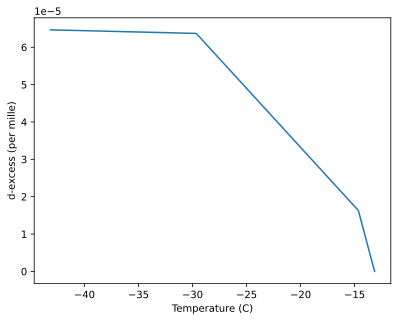

In [23]:
pyplot.plot(
    formulae.trivia.K2C(res.t),
    in_unit(
        formulae.isotope_meteoric_water_line.excess_d(
            delta_2H=res.y[0,:],
            delta_18O=res.y[1,:]
        ),
        PER_MILLE
    )
)
pyplot.gca().set(
    xlabel = 'Temperature (C)',
    ylabel = 'd-excess (per mille)'
)
show_plot('d_excess')